# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, dblquad
from scipy.optimize import minimize_scalar

from scipy.interpolate import interp1d, interp2d
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from fastcore.test import *

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
class Pbh(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                f_dm: float, # PBH fraction of the DM density
                mw_model=None,
                m31_model=None,
                l = None,
                b = None,
                u_t = 1,
                ds = 770,
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        if mass < m_low_interp or mass > m_high_interp:
            raise ValueError("PBH mass must be between 1e-16 and 1e-4 or a different interpolation function must be used for u_t")
        self.mass = mass
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
        # self.ut_interp = ut_interp
        self.ut_interp = ut_func_new
        self.u_t = u_t
        self.ds = ds
    
    def __str__(self) -> str:
        return f"PBH population with mass={self.mass} and f_dm={self.f_dm}"
    __repr__ = __str__

    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_mw, density_mw, velocity_dispersion_mw, finite=finite)
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_m31, density_m31, velocity_dispersion_m31, finite=finite)
    
    def differential_rate(self, t, integrand_func, finite=False):
        if finite:
            result, error = dblquad(integrand_func, 
                                    0, self.d_upper_bound(),
                                    lambda d: 0, 
                                    lambda d: self.umin_upper_bound(d),
                                    args=[t],
                                    epsabs=0,
                                    epsrel=1e-1,
                                    )
        else:
            result, error = dblquad(integrand_func,
                                        #Without finite size effects, integral blows up at M31 center
                                    0, self.ds*0.99,
                                    lambda d: 0, 
                                    lambda d: self.u_t,
                                    args=[t],
                                    epsabs=0,
                                    epsrel=1e-1,
                                    )
        return result

    def rate_total(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):        
        
        if efficiency is None:
            def efficiency(t):
                return 1
            
        point = self.sticking_point()

        def integrand(t, d, finite):
            if finite:
                u_bounds = [0, self.umin_upper_bound(d)]
            else:
                u_bounds = [0, self.u_t]
            u_result, _ = nquad(integrand_func, [u_bounds], args=(d, t))
            return u_result * efficiency(t)

        bounds_t = [tcad, tobs]

        if finite:
            bounds_d = [0, min(self.d_upper_bound(), self.ds)]
        else:
            bounds_d = [0, self.ds]

        opts = {"epsabs": epsabs, "epsrel": epsrel, "points":[point, self.ds]}

        result, error = nquad(integrand, [bounds_t, bounds_d], args=[finite], opts=opts)
        return result
    
            
    def d_upper_bound(self):
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d) == 0:
                return d
        return self.ds
    
    def rate_mw(self, finite=False):
        return self.rate_total(self.differential_rate_integrand_mw, finite=finite)
    
    def rate_m31(self, finite=False):
        result = self.rate_total(self.differential_rate_integrand_m31, finite=finite)
        if not np.isnan(result):
            return result
        else:
            return 0
        
    def rate_tot(self, finite=False):
        return self.rate_mw(finite=finite) + self.rate_m31(finite=finite)

    def differential_rate_mw(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)

    def differential_rate_m31(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def umin_upper_bound(self, d):
        # return self.ut_interp(d, self.mass)[0]
        rho = rho_func(self.mass, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]
    
    def sticking_point(self):
        #Determine where u_t is maximized. This speeds up the integral in m31
        result = minimize_scalar(lambda d: -self.umin_upper_bound(d), bounds=(0, self.ds), method='bounded')
        if result.success:
            return result.x[0] if isinstance(result.x, (list, np.ndarray)) else result.x
        else:
            return self.ds

In [ ]:
m_lens = 1e-8
pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds)
ts = np.logspace(-2,1,50)

In [ ]:
#test object creation
test_eq(pbh.mass, m_lens)

#test differential rate
test_eq(pbh.differential_rate_total(1), pbh.differential_rate_mw(1) + pbh.differential_rate_m31(1))

#test that threshold parameter is close to 1 for small d
test_close(pbh.umin_upper_bound(0), 1, eps=1e-2)

#test that threshold parameter is close to 0 when close to source
test_close(pbh.umin_upper_bound(ds*0.99), 0, eps=1e-2)

#test that umin lower bound is correctly inherited from Lens
test_eq(pbh.umin_lower_bound(0), 0)

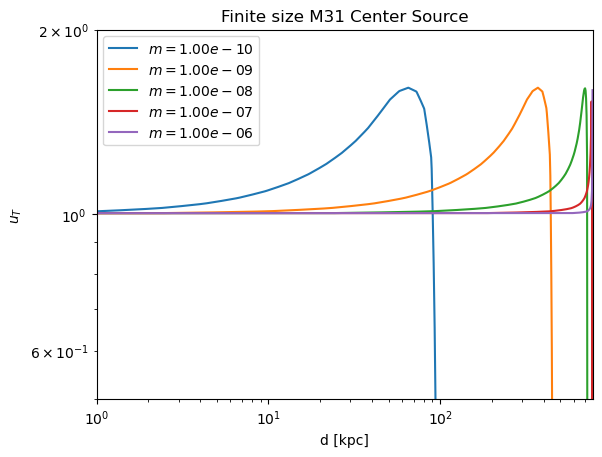

In [ ]:
d_arr = np.logspace(0, np.log10(ds*0.999), 1000)

m_pbh_arr = np.logspace(-10, -6, 5)

rhos_calc = [[rho_func(m, d, ds) for d in d_arr] for m in m_pbh_arr]

for m, rhos in zip(m_pbh_arr, rhos_calc):
    plt.plot(d_arr, ut_func_new(rhos, 1.34), label=f"$m= {m:.2e}$")

plt.xscale("log")
plt.yscale("log")
plt.xlim(min(d_arr), max(d_arr))
plt.ylim(5e-1, 2)

plt.xlabel("d [kpc]")
plt.ylabel("$u_{T}$")
plt.title("Finite size M31 Center Source")

plt.legend()
plt.show()

In [ ]:
result_mw = [pbh.differential_rate_mw(t, finite=False) for t in ts]
result_m31 = [pbh.differential_rate_m31(t, finite=False) for t in ts]

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  lo

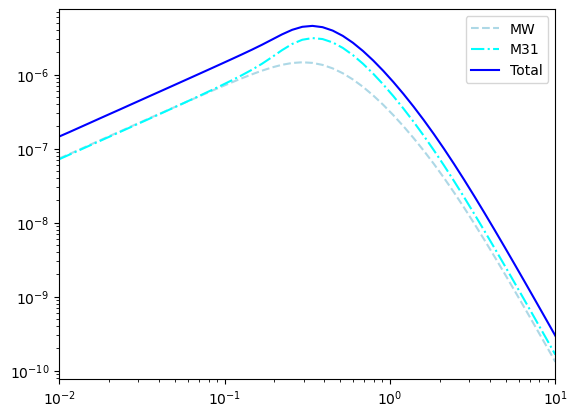

In [ ]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

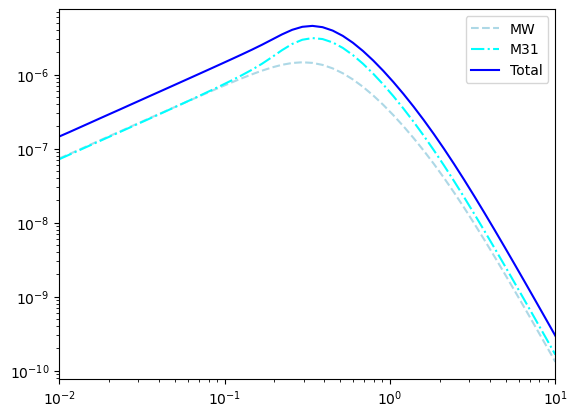

In [ ]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [ ]:
result_mw_finite = [pbh.differential_rate_mw(t, finite=True) for t in ts]
result_m31_finite = [pbh.differential_rate_m31(t, finite=True) for t in ts]

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  lo

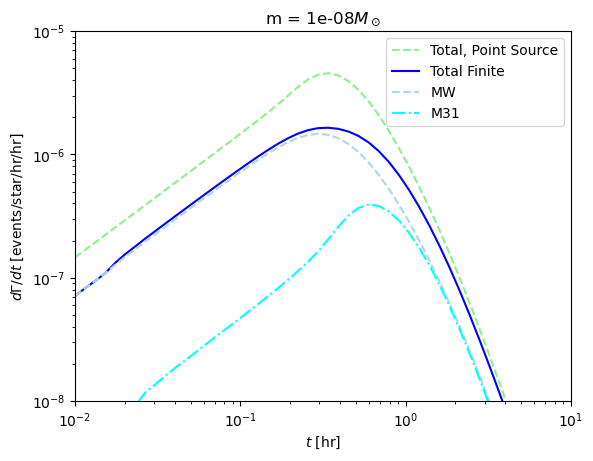

In [ ]:
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
plt.loglog(ts, np.array(result_mw_finite) + np.array(result_m31_finite), label="Total Finite", color="blue")
plt.loglog(ts, result_mw_finite, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31_finite, label="M31", color="cyan", linestyle="-.")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(pbh.mass) + r"$M_\odot$")
plt.legend()
plt.show()

In [ ]:
ts = np.logspace(-2, 3, 30)
pbhs = [Pbh(10**(i), 1, l=l, b=b) for i in np.linspace(-5, -3, 3)]

result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    result[i] = pbh.compute_differential_rate(ts, finite=False)

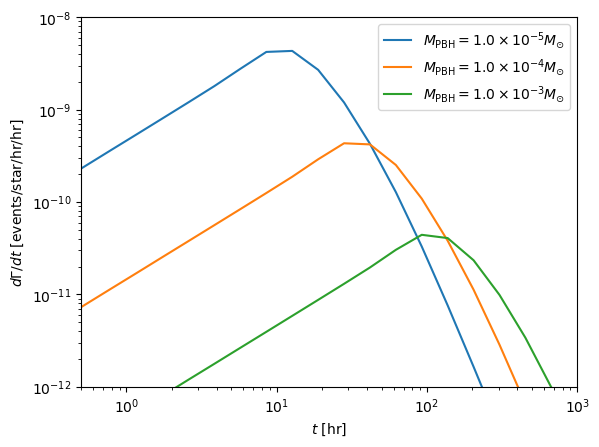

In [ ]:
for i, pbh in enumerate(pbhs):
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.mass,0) + "$M_{\odot}$")

plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(5e-1, 1e3)
plt.ylim(1e-12, 1e-8)

plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()